# Daten erkunden und überprüfen

Wir laden beide Datasets, schauen uns die Daten an und überprüfen, ob die Daten unseren Vorstellungen entsprechen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mtpl.data_util import load_freq_df, load_sev_df, print_data_summary

## Daten laden

Vertragsdatensatz:

In [2]:
freq_df = load_freq_df()
n_freq = freq_df.shape[0]
print(n_freq)
freq_df.head(5)

678013


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


Schadensfalldatensatz:

In [3]:
sev_df = load_sev_df()
n_sev = sev_df.shape[0]
print(n_sev)
sev_df.head(5)

26639


,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11
3,4007252,1204.00
4,4046424,1204.00


## Spalten erkunden

In [4]:
freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  int64  
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 62.1+ MB


In [5]:
sev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  int64  
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 416.4 KB


Es gibt keine null-Werte, eine Sorge weniger.

### IDpol
IDPol ist der identifier des Datensatzes. Im Vertragsdatensatz sollte jede id nur einmal vorkommen.

In [6]:
n_freq - freq_df["IDpol"].unique().size

0

Im Schadensdatensatz kann eine ID auch mehrmals vorkommen, da es mehrere Schäden pro Vertrag geben kann.

In [7]:
sev_df["IDpol"].value_counts(ascending=False).head(5)

IDpol
2262511    66
2282134    36
2227533    25
2220367    24
2277846    23
Name: count, dtype: int64

In [8]:
non_match = sev_df["IDpol"].unique().size - np.intersect1d(freq_df["IDpol"].unique(), sev_df["IDpol"].unique()).size
print(f"{non_match} IDs aus dem Schadensdatensatz sind nicht im Vertragsdatensatz zu finden.")

6 IDs aus dem Schadensdatensatz sind nicht im Vertragsdatensatz zu finden.


### ClaimNb

In [9]:
freq_has_claim = freq_df[freq_df["ClaimNb"] > 0].shape[0]
print("{:d} Verträge haben mindestens einen Claim, das entspricht {:.2f}%".format(freq_has_claim, freq_has_claim / n_freq * 100))
print("Claims insgesamt: ", freq_df["ClaimNb"].sum())

34060 Verträge haben mindestens einen Claim, das entspricht 5.02%
Claims insgesamt:  36102.0


Wie zu erwarten sind die meisten Verträge ohne Schadensfall. Wir werden später ein Modell und Fehlerfunktion wählen, das mit dieser Verteilung in der Zielvariablen umgehen kann.

In [10]:
freq_df["ClaimNb"].value_counts().sort_index()

ClaimNb
0.0     643953
1.0      32178
2.0       1784
3.0         82
4.0          7
5.0          2
6.0          1
8.0          1
9.0          1
11.0         3
16.0         1
Name: count, dtype: int64

### Merge
Bevor wir fortfahren, führen wir die Vertragsdaten und die Schadensfälle per left join zusammen.

In [11]:
claims_by_pol = sev_df.groupby("IDpol").agg(
    claim_count=pd.NamedAgg(column="IDpol", aggfunc="count"),
    claim_amount=pd.NamedAgg(column="ClaimAmount", aggfunc="sum"),
)
merge_df = freq_df.merge(claims_by_pol, how="left", left_on="IDpol", right_index=True)
merge_df["claim_count"] = merge_df["claim_count"].fillna(0)
merge_df["claim_amount"] = merge_df["claim_amount"].fillna(0.0)
merge_df[merge_df["claim_count"] > 0].head(5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,claim_count,claim_amount
66,139,1.0,0.75,F,7.0,1.0,61.0,50.0,B12,Regular,27000.0,R11,1.0,303.00
93,190,1.0,0.14,B,12.0,5.0,50.0,60.0,B12,Diesel,56.0,R25,1.0,1981.84
199,414,1.0,0.14,E,4.0,0.0,36.0,85.0,B12,Regular,4792.0,R11,1.0,1456.55
205,424,2.0,0.62,F,10.0,0.0,51.0,100.0,B12,Regular,27000.0,R11,2.0,10834.00
223,463,1.0,0.31,A,5.0,0.0,45.0,50.0,B12,Regular,12.0,R73,1.0,3986.67


In [12]:
merge_df["claim_count"].value_counts().sort_index()

claim_count
0.0     653069
1.0      23571
2.0       1298
3.0         62
4.0          5
5.0          2
6.0          1
8.0          1
9.0          1
11.0         2
16.0         1
Name: count, dtype: int64

In [13]:
merge_df[merge_df["ClaimNb"] != merge_df["claim_count"]].groupby(["ClaimNb", "claim_count"])["IDpol"].count()

ClaimNb  claim_count
1.0      0.0            8608
2.0      0.0             485
         1.0               1
3.0      0.0              20
4.0      0.0               2
11.0     0.0               1
Name: IDpol, dtype: int64

Für einige Reihen haben wir nicht so viele Schadensfälle, wie im Vertragsdatensatz angegeben. Das ist schlecht, weil unsere Zielvariable damit noch öfter den Wert 0 haben wird, als bisher angenommen. Wir werden diese Reihen von jetzt an ignorieren, da es sich wahrscheinlich um fehlerhafte Daten handelt.

In [14]:
df = merge_df[merge_df["ClaimNb"] == merge_df["claim_count"]].copy()
n = df.shape[0]
n_has_claim = df[df["claim_count"] > 0].shape[0]
n_pos_amount = df[df["claim_amount"] > 0].shape[0]
print(f"{n_pos_amount} Veträge haben einen positiven claim_amount.")
print(f"{n_has_claim} Verträge haben mindestens einen Schadensfall.")
print("Das entspricht {:.2f}% aller Verträge.".format(n_has_claim / n * 100))

24943 Veträge haben einen positiven claim_amount.
24943 Verträge haben mindestens einen Schadensfall.
Das entspricht 3.73% aller Verträge.


### Exposure

In [15]:
df["Exposure"].describe()

count    668896.000000
mean          0.529071
std           0.364249
min           0.002732
25%           0.180000
50%           0.490000
75%           0.990000
max           2.010000
Name: Exposure, dtype: float64

<Axes: >

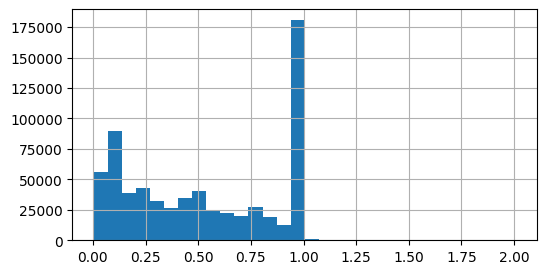

In [16]:
df["Exposure"].hist(bins=30, figsize=(6,3))

Sehr kurze Vertragslaufzeiten können zu Ausreißern in der Zielvariable führen. Das werden wir später genauer überprüfen.

In [17]:
print_data_summary(df[df["Exposure"] >= 0.1], "claim_amount")
print_data_summary(df[df["Exposure"] < 0.1], "claim_amount")

Daten 549228, positive Zielvariable: 23845 (4.34%)
Daten 119668, positive Zielvariable: 1098 (0.92%)


In [18]:
df["claims_per_year"] = df["claim_count"] / df["Exposure"]
df[["claims_per_year", "claim_count", "Exposure"]].sort_values("claims_per_year", ascending=False).head(5)

,claims_per_year,claim_count,Exposure
262178,365.000000,1.0,0.002740
286602,365.000000,1.0,0.002740
401872,365.000000,1.0,0.002740
604298,365.000000,2.0,0.005479
617664,243.333333,2.0,0.008219


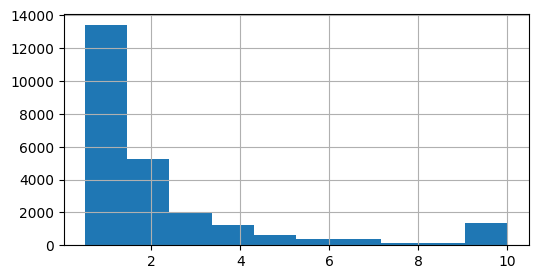

In [19]:
df[df["claims_per_year"] > 0]["claims_per_year"].clip(upper=10).hist(bins=10, figsize=(6,3));

### Zielvariable claim_amount_per_year

In [20]:
df["claim_amount_per_year"] = df["claim_amount"] / df["Exposure"]
df[["claim_amount_per_year", "claim_amount", "Exposure"]].sort_values("claim_amount_per_year", ascending=False).head(5)

,claim_amount_per_year,claim_amount,Exposure
150027,1.852455e+07,4075400.56,0.22
25274,1.830737e+07,183073.66,0.01
399662,9.102500e+06,182050.00,0.02
368669,4.255057e+06,382955.14,0.09
270621,4.066164e+06,1301172.60,0.32


In [21]:
has_claim_df = df[df["claim_amount"] > 0]
for q in [0.9 + i/100 for i in range(10)]:
    print("{:.3f}: {:10.2f}".format(q, has_claim_df["claim_amount_per_year"].quantile(q)))

0.900:    9208.87
0.910:   10141.39
0.920:   11721.51
0.930:   13377.78
0.940:   15814.59
0.950:   18910.70
0.960:   23664.58
0.970:   31356.02
0.980:   50000.00
0.990:  110893.71


Wir können später versuchen im Trainingsdatensatz die Zielvariable auf einen Maximalwert zu clippen.

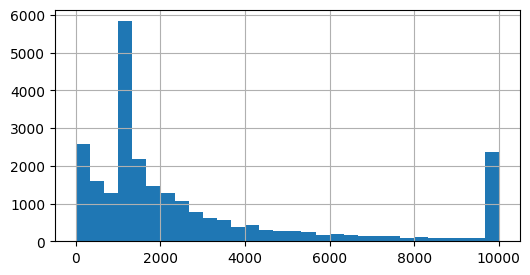

In [22]:
df[df["claim_amount_per_year"] > 0]["claim_amount_per_year"].clip(upper=1e4).hist(bins=30, figsize=(6,3));

### Kategorische Features
Wir schauen uns für jedes kategorische Feature die Kardinalität an.

In [23]:
categorical_features = ["Area", "VehBrand", "VehGas", "Region"]
for f in categorical_features:
    print(f"{f}:", df[f].unique().size)
    s = df[f].value_counts()
    t = 2000
    s = s[s<t].copy()
    if s.shape[0] > 0:
        print(f"Folgende Werte kommen weniger als {t} mal vor:", s.to_dict())
    

Area: 6
VehBrand: 11
VehGas: 2
Region: 22
Folgende Werte kommen weniger als 2000 mal vor: {'R43': 1308}


Die Kardinalität der kategorischen Features ist nicht zu groß und es gibt keine Werte die nicht zu selten vorkommen.

### Numerische Features
Wir schauen uns zu jedem numerischen Feature die Verteilung im Histogram an.

In [24]:
numerical_features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]

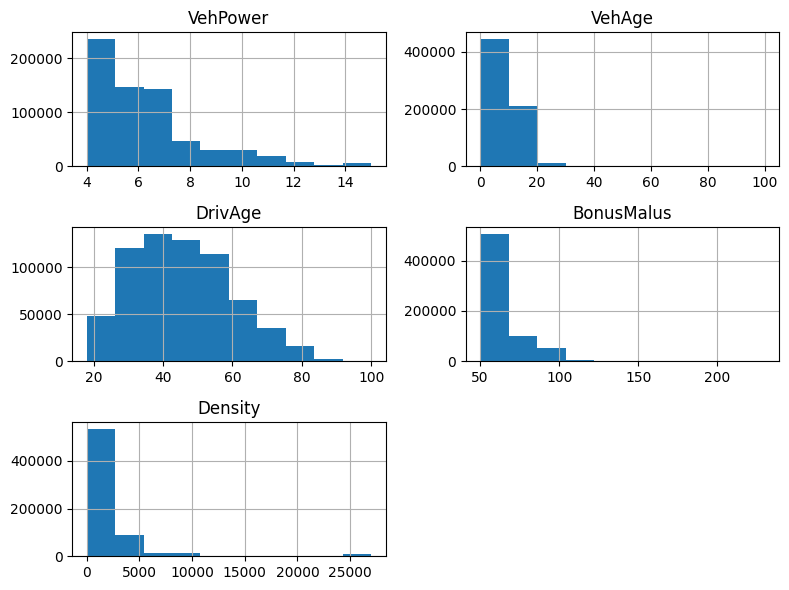

In [25]:
df[numerical_features].hist(bins=10, figsize=(8, 6), layout=(3, 2))
plt.tight_layout()
plt.show()

Die numerischen Features sind alle nicht-negativ und haben nach oben einige Extremwerte. Wir werden die Werte auf das 95%-Quantil clippen.

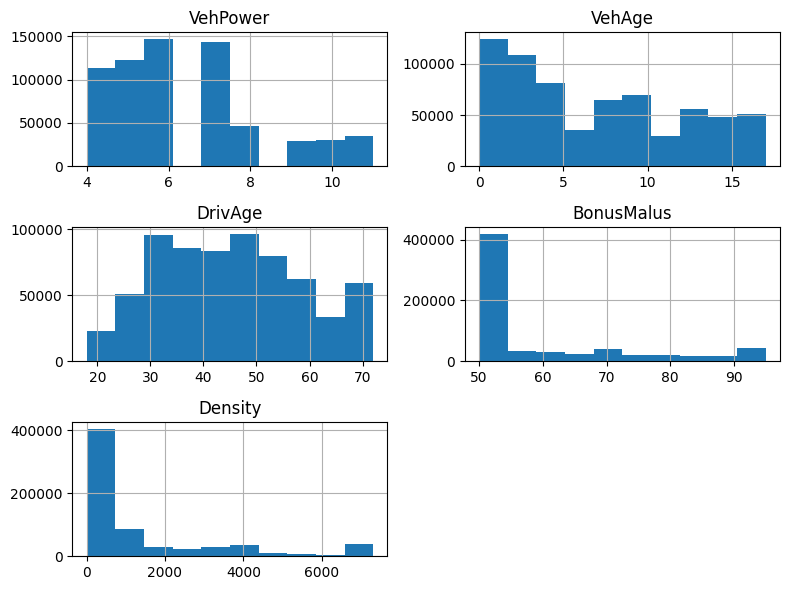

In [26]:
df[numerical_features].clip(upper=df[numerical_features].quantile(0.95), axis=1).hist(bins=10, figsize=(8, 6), layout=(3, 2))
plt.tight_layout()
plt.show()